### Modelo supervisado de regresión para predecir ventas de productos por tienda
* Autor: Alexis Castillo
* Lenguaje: Python

### Librerías y carga de datos de entrenamiento

In [1]:
# Scikit-Learn 
import sklearn

# Librerías para el tratamiento de datos
import pandas as pd
import numpy as np
from datetime import datetime

# Configuración de tamaño de gráficos
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignorar las advertencias no referenciales
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Semilla aleatoria
np.random.seed(123)

In [2]:
# Conexion a Google Colaborative
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# Carga data de entrenamiento
df = pd.read_csv('/gdrive/MyDrive/Challenge PiData/data/Train_BigMart.csv')
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [ ]:
# Se verifica que el dataset es pequeño (Podría funcionar un modelo de regresión lineal)
df.shape

(8523, 12)

### Limpieza de datos en el dataset

In [4]:
# Corrijo formato de valores en Item_Fat_Content
df.Item_Fat_Content.replace({"low fat": 'Low Fat', "LF": 'Low Fat', "reg": 'Regular'}, inplace=True)

### Tratamiento de valores nulos

In [ ]:
# Razón de valores nulos por feature
df.isnull().sum()/df.shape[0]

Item_Identifier              0.000000
Item_Weight                  0.171653
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282764
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
Item_Outlet_Sales            0.000000
dtype: float64

In [ ]:
# Se observa que en el año 1985 (año más antiguo) no se registraron los pesos de los productos
# Posiblemente en ese año aún no se contaba con un sistema de registros de los pesos de los productos
df[df['Item_Weight'].isnull()]['Outlet_Establishment_Year'].unique()

array([1985])

In [ ]:
# Estas 3 tiendas no registran su tamaño
df[df['Outlet_Size'].isnull()]['Outlet_Identifier'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [ ]:
# Hay más tiendas Small del tipo Supermarket Type1
# Se sugiere reemplazar por Small aquellas tiendas de valor nulo en su tamaño de tipo Supermarket Type1
df[df['Outlet_Type']=='Supermarket Type1'].groupby(['Outlet_Size'])['Outlet_Identifier'].nunique()

Outlet_Size
High      1
Medium    1
Small     2
Name: Outlet_Identifier, dtype: int64

In [ ]:
# Una bodega por lo general es un establecimiento pequeño
# Se sugiere rellenar valores nulos de Outlet_Size de tipo Grocery Store como "Small"
df[df['Outlet_Type']=='Grocery Store']['Outlet_Size'].unique()

array([nan, 'Small'], dtype=object)

In [5]:
# Completando valores nulos:
# Para Item_Weight:
df_1 = pd.DataFrame()
for i in df.Item_Identifier.unique():
  df_item = df[df['Item_Identifier'] == i]
  df_item['Item_Weight'].fillna(df_item['Item_Weight'].mean(), axis=0, inplace=True)
  df_1 = pd.concat([df_1, df_item], axis=0)
  df_1.reset_index(drop=True, inplace=True)
# Quedan producto que se compraron solo una vez y sin registro de Item_Weight, reemplazo por el valor de la mediana del total
df_1['Item_Weight'].fillna(df_1['Item_Weight'].median(), axis=0, inplace=True)
# Para Outlet_Size:
df_1['Outlet_Size'].fillna('Small', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [6]:
# Redefino el dataset tomando el df_1 con valores completos
df = df_1.copy()

In [ ]:
# Se verifica que los datos están completos
df.isnull().sum()

Outlet_Item                  0
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Antiquity_Outlet             0
dtype: int64

### Análisis descriptivo para validar las asunciones del negocio con repecto a ciertas características de la tienda y los productos

In [ ]:
# Se menciona que la ubicación de la tienda puede influir en las ventas
Ind_Sales_Outlet_Location_Type = df.pivot_table(index = ['Outlet_Location_Type'], 
                      aggfunc = {'Item_Outlet_Sales': ['mean', 'sum','nunique']}).round(2).fillna(0).reset_index()

Ind_Sales_Outlet_Location_Type.columns = ['Outlet_Location_Type','Avg_Sales','Num_Sales','Total_Sales']
Ind_Sales_Outlet_Location_Type.sort_values(by='Total_Sales', ascending=False)
# Las tiendas con ubicación del tipo Tier 3 tienen mayor venta total y productos vendidos, 
# los clientes prefieren comprar en tiendas más cercanas a su hogar

,Outlet_Location_Type,Avg_Sales,Num_Sales,Total_Sales
2,Tier 3,2279.63,2195,7636752.63
1,Tier 2,2323.99,1778,6472313.71
0,Tier 1,1876.91,1642,4482059.07


In [ ]:
# Se menciona que el tamaño de la tienda puede influir en las ventas
Ind_Sales_Outlet_Size = df.pivot_table(index = ['Outlet_Size'], 
                      aggfunc = {'Item_Outlet_Sales': ['mean', 'sum','nunique']}).round(2).fillna(0).reset_index()

Ind_Sales_Outlet_Size.columns = ['Outlet_Size','Avg_Sales','Num_Sales','Total_Sales']
Ind_Sales_Outlet_Size.sort_values(by='Total_Sales', ascending=False)
# Las tiendas pequeñas venden más, pero generan un promedio de ventas bajo, más barato.

,Outlet_Size,Avg_Sales,Num_Sales,Total_Sales
2,Small,1867.18,2506,8958743.14
1,Medium,2681.60,1920,7489718.69
0,High,2299.00,788,2142663.58


In [ ]:
# Se menciona que el tipo de tienda puede influir en la venta
Ind_Sales_Outlet_Type = df.pivot_table(index = ['Outlet_Type'], 
                      aggfunc = {'Item_Outlet_Sales': ['mean', 'sum','nunique']}).round(2).fillna(0).reset_index()

Ind_Sales_Outlet_Type.columns = ['Outlet_Type','Avg_Sales','Num_Sales','Total_Sales']
Ind_Sales_Outlet_Type.sort_values(by='Total_Sales', ascending=False)
# Se prefiere comprar en supermercados, establecimientos donde pueden encontrar mayor variedad de productos

,Outlet_Type,Avg_Sales,Num_Sales,Total_Sales
1,Supermarket Type1,2316.18,2674,12917342.26
3,Supermarket Type3,3694.04,827,3453926.05
2,Supermarket Type2,1995.50,779,1851822.83
0,Grocery Store,339.83,571,368034.27


In [ ]:
# Se menciona que los productos de la categoría bebidas alcohólicas (Hard Drinks) se venden menos 
Ind_Sales_Item_Type = df.pivot_table(index = ['Item_Type'], 
                      aggfunc = {'Item_Outlet_Sales': ['mean', 'sum','nunique']}).round(2).fillna(0).reset_index()

Ind_Sales_Item_Type.columns = ['Item_Type','Avg_Sales','Num_Sales','Total_Sales']
Ind_Sales_Item_Type.sort_values(by='Total_Sales', ascending=False)
# Efectivamente las bebidas alcohólicas son una de las categorías menos vendidas

,Item_Type,Avg_Sales,Num_Sales,Total_Sales
6,Fruits and Vegetables,2289.01,995,2820059.82
13,Snack Foods,2277.32,929,2732786.09
9,Household,2258.78,764,2055493.71
5,Frozen Foods,2132.87,698,1825734.79
4,Dairy,2232.54,571,1522594.05
3,Canned,2225.19,558,1444151.49
0,Baking Goods,1952.97,536,1265525.34
8,Health and Hygiene,2010.00,442,1045200.14
10,Meat,2158.98,381,917565.61
14,Soft Drinks,2006.51,377,892897.72


### Se define percentiles

In [7]:
# Se define percentiles
percentiles = list(np.arange(0, 0.4, 0.01)) + list(np.arange(0.4, 0.8, 0.1)) + list(np.arange(0.8, 1.0, 0.01))

### Outliers en target (Variable a predecir)

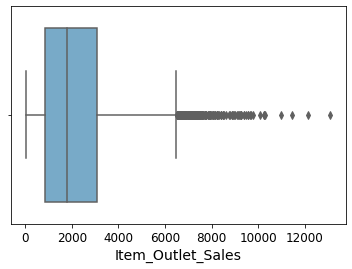

In [ ]:
# Revisión outliers en target
sns.boxplot(x=df['Item_Outlet_Sales'], palette="Blues")
plt.show()

In [ ]:
descript = df['Item_Outlet_Sales'].describe(percentiles = percentiles)
descript.tail(10)

91%     4710.548316
92%     4870.486792
93%     5070.732800
94%     5313.084000
95%     5522.811000
96%     5816.428800
97%     6094.307088
98%     6623.831144
99%     7366.011720
max    13086.964800
Name: Item_Outlet_Sales, dtype: float64

In [8]:
# Tomo el percentil 99 del target
p99 = np.percentile(df['Item_Outlet_Sales'], 99)
# Elimino registros con valor de venta outlier del percentil 99
df = df[df['Item_Outlet_Sales'] < p99].copy()

### Tratamiento de outliers en features numéricos

In [9]:
# Variables
num_features = ['Item_Weight','Item_Visibility','Item_MRP']
cat_features = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']

In [ ]:
# Se observa que la media y mediana es similar para todos los features, se puede decir que no hay outliers (Es solo una primera hipótesis)
df[num_features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Item_Weight,8437.0,12.868102,4.644599,4.555,8.785000,12.600000,16.850000,21.350000
Item_Visibility,8437.0,0.066224,0.051706,0.000,0.026993,0.053939,0.095045,0.328391
Item_MRP,8437.0,140.134933,61.921308,31.290,93.409400,142.015400,184.795000,266.888400


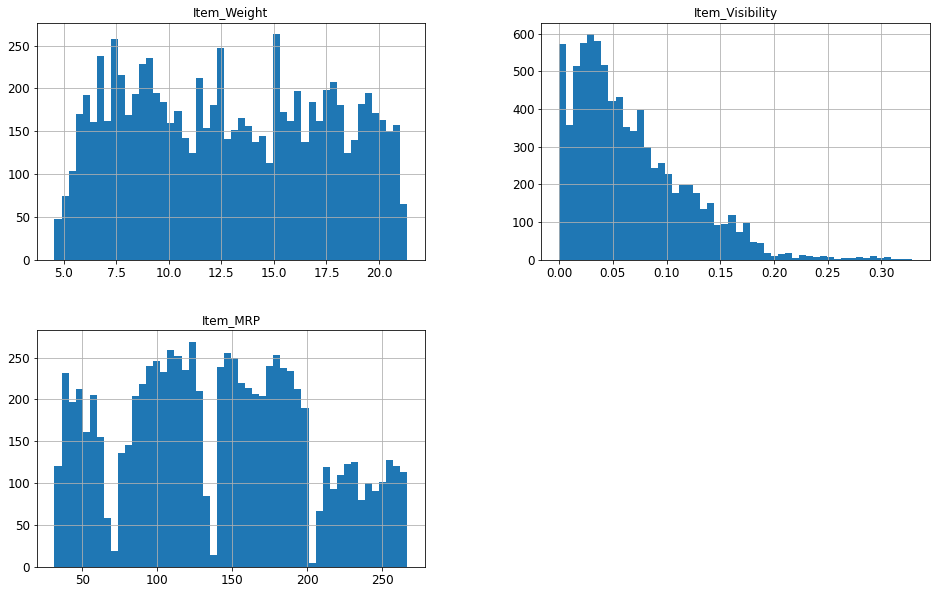

In [ ]:
# Distribución de features numéricos
df[num_features].hist(bins=50, figsize=(16,10))
plt.show()

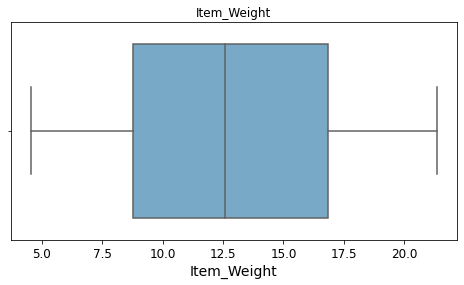

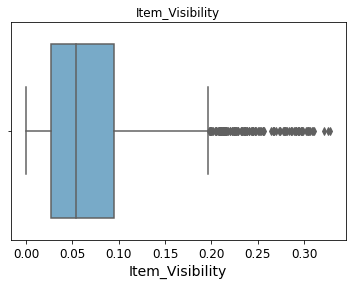

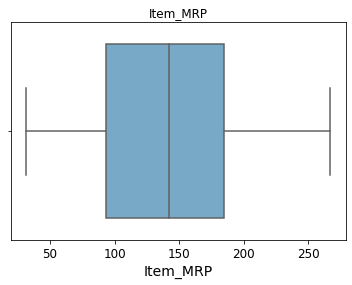

In [ ]:
# Gráfico de cajas para identificar dispersion, forma y atipicos:
plt.figure(figsize=(8,4))
for x in num_features:
  plt.title(df[x].name)
  sns.boxplot(x=df[x], palette="Blues");
  plt.show()

In [ ]:
# Se observa presencia de valores outlier en Item_Visibility
descript = df['Item_Visibility'].describe(percentiles = percentiles)
descript.tail(10)

91%    0.142891
92%    0.148175
93%    0.153605
94%    0.159792
95%    0.163904
96%    0.171371
97%    0.176734
98%    0.187638
99%    0.226864
max    0.328391
Name: Item_Visibility, dtype: float64

In [10]:
# Reemplazo valores outlier por encima del percentil 98 por el valor de la mediana
p98 = np.percentile(df['Item_Visibility'], 98)
df['Item_Visibility'] = np.where(df['Item_Visibility'] > p98, df['Item_Visibility'].median(), df['Item_Visibility'])

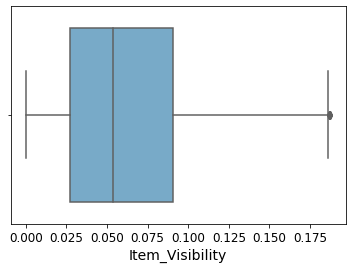

In [ ]:
# Se observa la reducción de valores outliers en Item_Visibility
sns.boxplot(x=df['Item_Visibility'], palette="Blues")
plt.show()

### Feature Engineering

In [11]:
# Librería para implementar el Target encoding
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.4 MB/s 


In [12]:
from category_encoders import TargetEncoder
encoder = TargetEncoder()

df[[x + '_num' for x in cat_features]] = encoder.fit_transform(df[cat_features], df['Item_Outlet_Sales'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [13]:
# Genero variable antiguedad de la tienda, posiblemente las más nuevas tengan menores precios de venta
df['Antiquity_Outlet'] = int(datetime.today().strftime('%Y')) - df['Outlet_Establishment_Year']
df['Price_max_manufacturing'] = df['Item_Weight'] * df['Item_MRP'] # Precio máximo por peso de producto

In [14]:
var_poly = list(df.drop(['Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Establishment_Year',
                    'Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Outlet_Sales'], axis=1).columns)
for i in var_poly:
  df[i+'_2'] = df[i]*df[i]
  df[i+'_3'] = df[i]*df[i]*df[i]

In [15]:
# Considerando que un producto bajo en grasas se diferencia en precios sobre otro similar
df['Item_Fat_Content_est'] = np.where(df['Item_Fat_Content'] == 'Low Fat', 1, 0)
# Considerando que una bebida alcohólica tiene menor demanda, en consecuencia mayor precio
df['Item_Typet_est'] = np.where(df['Item_Type'] == 'Hard Drinks', 0, 1)
# Considerando que un establecimiento pequeño vende más
df['Outlet_Size_est'] = np.where(df['Outlet_Size'] == 'Small', 1, 0)
# Considerando que una bodega tiene menores ventas
df['Outlet_Type_est'] = np.where(df['Outlet_Type'] == 'Grocery Store', 0, 1)
# Considerando que una tienda menos centralizada o urbana (Tier 3) genera mayores ventas
df['Outlet_Location_Type_est'] = np.where(df['Outlet_Location_Type'] == 'Tier 3', 1, 0)

In [16]:
df_all_vars = df.copy()

In [17]:
#Variables para el modelo

num_features = ['Item_Visibility','Item_MRP','Antiquity_Outlet',
                'Item_Weight_3','Item_Fat_Content_num_2', 'Item_Type_num_2', 'Outlet_Size_num_2',
                'Outlet_Location_Type_num_2','Outlet_Type_num_2']
cat_features = ['Item_Fat_Content_est', 'Item_Typet_est','Outlet_Size_est', 'Outlet_Location_Type_est']

X = df[num_features + cat_features]
y = df.Item_Outlet_Sales

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


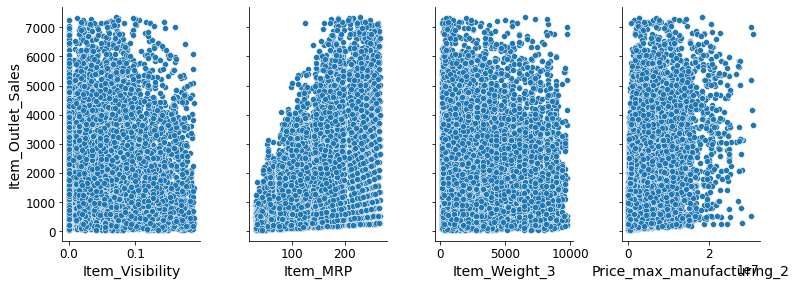

In [18]:
# Verificación de supuesto de linealidad de features respecto al target
lin = sns.pairplot(df, x_vars = ['Item_Visibility','Item_MRP','Item_Weight_3','Price_max_manufacturing_2'],
                 y_vars='Item_Outlet_Sales', size=4, aspect=0.7)
plt.show()

In [20]:
# Se valida multicolinealidad
df.corr(method='spearman')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_num,Item_Type_num,Outlet_Size_num,Outlet_Location_Type_num,Outlet_Type_num,...,Outlet_Type_num_3,Antiquity_Outlet_2,Antiquity_Outlet_3,Price_max_manufacturing_2,Price_max_manufacturing_3,Item_Fat_Content_est,Item_Typet_est,Outlet_Size_est,Outlet_Type_est,Outlet_Location_Type_est
Item_Weight,1.000000,-0.005550,0.028003,-0.010061,0.007819,-0.025632,0.059585,0.007269,-0.012671,-0.004836,...,-0.004836,0.010061,0.010061,0.617026,0.617026,0.025632,0.046920,-0.009307,-0.007527,0.008389
Item_Visibility,-0.005550,1.000000,0.007507,-0.029546,-0.070607,0.053002,-0.009345,-0.045912,-0.028160,-0.087942,...,-0.087942,0.029546,0.029546,0.001500,0.001500,-0.053002,0.000328,0.047456,-0.119563,0.001940
Item_MRP,0.028003,0.007507,1.000000,0.014464,0.554208,0.006893,0.090817,-0.012618,0.001223,-0.019350,...,-0.019350,-0.014464,-0.014464,0.776376,0.776376,-0.006893,0.006008,0.010864,-0.002867,-0.007972
Outlet_Establishment_Year,-0.010061,-0.029546,0.014464,1.000000,0.059489,0.002756,0.004807,-0.093179,0.531464,-0.279598,...,-0.279598,-1.000000,-1.000000,0.003615,0.003615,-0.002756,-0.005073,0.170802,0.327444,-0.217104
Item_Outlet_Sales,0.007819,-0.070607,0.554208,0.059489,1.000000,0.019313,0.065162,0.223670,0.135613,0.494341,...,0.494341,-0.059489,-0.059489,0.440036,0.440036,-0.019313,-0.001152,-0.220554,0.536356,-0.006398
Item_Fat_Content_num,-0.025632,0.053002,0.006893,0.002756,0.019313,1.000000,-0.011542,0.004074,-0.004085,0.000741,...,0.000741,-0.002756,-0.002756,-0.008944,-0.008944,-1.000000,0.118803,-0.003327,0.002973,-0.000069
Item_Type_num,0.059585,-0.009345,0.090817,0.004807,0.065162,-0.011542,1.000000,0.009130,0.009929,0.009142,...,0.009142,-0.004807,-0.004807,0.098729,0.098729,0.011542,0.019790,-0.008541,0.010315,0.005224
Outlet_Size_num,0.007269,-0.045912,-0.012618,-0.093179,0.223670,0.004074,0.009130,1.000000,-0.367589,0.211189,...,0.211189,0.093179,0.093179,-0.005264,-0.005264,-0.004074,-0.008425,-0.969941,0.325886,0.573046
Outlet_Location_Type_num,-0.012671,-0.028160,0.001223,0.531464,0.135613,-0.004085,0.009929,-0.367589,1.000000,0.183526,...,0.183526,-0.531464,-0.531464,-0.008696,-0.008696,0.004085,-0.004070,0.348781,0.264246,-0.067754
Outlet_Type_num,-0.004836,-0.087942,-0.019350,-0.279598,0.494341,0.000741,0.009142,0.211189,0.183526,1.000000,...,1.000000,0.279598,0.279598,-0.018163,-0.018163,-0.000741,-0.007903,-0.220088,0.687050,-0.079964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


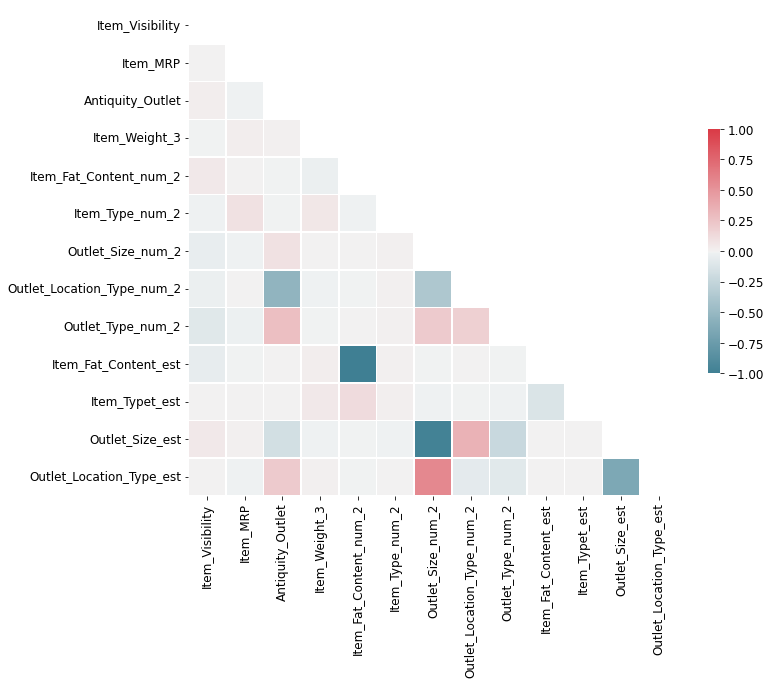

In [22]:
# Multicolinealidad
corr = X.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
# Estandarizo las variables
for col in list(X.columns):
  X[col] = (X[col] - np.mean(X[col])) / np.std(X[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# Columna necesaria para generar el modelo de regresión lineal
X['intercepto'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# Muestreo de data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123)

In [ ]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(8437, 14)
(5905, 14)
(2532, 14)


### Modelo Regresión lineal múltiple  SGD

In [26]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=2000, tol=1e-3, penalty=None,  eta0=0.001, random_state=123)
sgd_reg.fit(X_train, y_train)

sgd_reg.score(X_train, y_train)

0.5672633589449689

In [ ]:
# Coeficientes de las variables del modelo
sgd_reg.coef_

array([ -23.76592831,  912.48268238, -224.76535859,  -18.92511937,
          6.02163195,   17.60858329, -488.2990775 ,  -37.22333611,
        796.99753359,   -6.02163195,  -11.00326824, -583.12934257,
       -109.17698497, 1056.74730911])

In [27]:
# Se obtiene la importancia de cada variable para el modelo
feature_importance = pd.DataFrame({'feature':X_train.columns.tolist(),
                                   'parámetro':sgd_reg.coef_,
                                   'importancia': abs(sgd_reg.coef_)}).sort_values(by='importancia', ascending=False)
feature_importance.drop(feature_importance[feature_importance['feature'] == 'intercepto'].index , inplace=True)                                 
feature_importance['pesos_features']=feature_importance['importancia']/sum(feature_importance['importancia'])
feature_importance                                 

,feature,parámetro,importancia,pesos_features
1,Item_MRP,912.482682,912.482682,0.282029
8,Outlet_Type_num_2,796.997534,796.997534,0.246335
11,Outlet_Size_est,-583.129343,583.129343,0.180233
6,Outlet_Size_num_2,-488.299077,488.299077,0.150923
2,Antiquity_Outlet,-224.765359,224.765359,0.069470
12,Outlet_Location_Type_est,-109.176985,109.176985,0.033744
7,Outlet_Location_Type_num_2,-37.223336,37.223336,0.011505
0,Item_Visibility,-23.765928,23.765928,0.007346
3,Item_Weight_3,-18.925119,18.925119,0.005849
5,Item_Type_num_2,17.608583,17.608583,0.005442


In [28]:
# Se predice la variable target con el modelo sgd_reg 
y_predicted_train = sgd_reg.predict(X_train)
y_predicted_test = sgd_reg.predict(X_test)

In [29]:
from sklearn.metrics import *
np.set_printoptions(suppress=True)
metrics_sgd_reg = pd.DataFrame({'metric':['R2','MAE','MSE','MRE'],
                                'sgd_reg_train':[r2_score(y_train, y_predicted_train),
                                        mean_absolute_error(y_train, y_predicted_train),
                                        mean_squared_error(y_train, y_predicted_train),
                                        max_error(y_train, y_predicted_train)],

                                'sgd_reg_test':[r2_score(y_test, y_predicted_test),
                                        mean_absolute_error(y_test, y_predicted_test),
                                        mean_squared_error(y_test, y_predicted_test),
                                        max_error(y_test, y_predicted_test)]})

metrics_sgd_reg.round(3)

,metric,sgd_reg_train,sgd_reg_test
0,R2,0.567,0.545
1,MAE,791.298,816.072
2,MSE,1088213.053,1146794.790
3,MRE,4499.522,4404.630


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


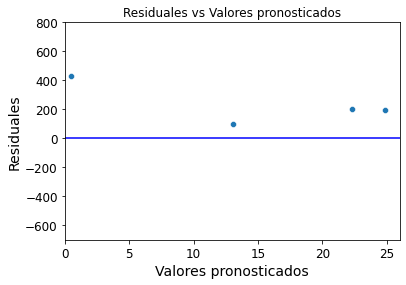

In [34]:
# Validación de supuesto de Homocedasticidad
residuals = y_test.values-y_predicted_test
p = sns.scatterplot(y_predicted_test,residuals)
plt.xlabel('Valores pronosticados')
plt.ylabel('Residuales')
plt.ylim(-700,800)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuales vs Valores pronosticados')

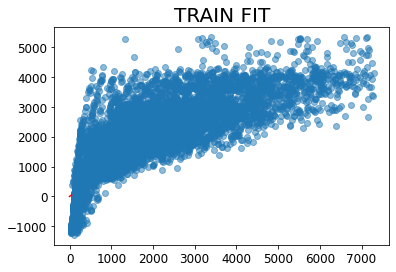

In [35]:
plt.title('TRAIN FIT', fontsize=20)
plt.scatter(y_train, y_predicted_train, alpha = 0.5)
plt.plot([0, 50], [0, 50], c='red')

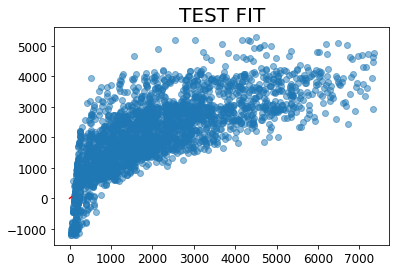

In [ ]:
plt.title('TEST FIT', fontsize=20)
plt.scatter(y_test, y_predicted_test, alpha = 0.5)
plt.plot([0, 50], [0, 50], c='red')

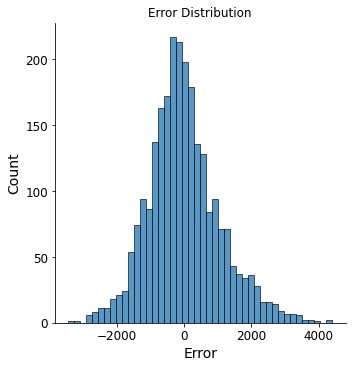

In [ ]:
# Se observa el supuesto de la distribución normal del error
error = y_test - y_predicted_test
sns.displot(error).set(title='Error Distribution', xlabel='Error')

### Regresión penalizada Ridge

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [ ]:
alphas = 10**np.linspace(10,-1,100)*0.5
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipel

(100, 14)

In [ ]:
# Cross Validation para obtener el alpha óptimo
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


RidgeCV(alphas=array([5.00000000e+09, 3.87131841e+09, 2.99742125e+09, 2.32079442e+09,
       1.79690683e+09, 1.39127970e+09, 1.07721735e+09, 8.34050269e+08,
       6.45774833e+08, 5.00000000e+08, 3.87131841e+08, 2.99742125e+08,
       2.32079442e+08, 1.79690683e+08, 1.39127970e+08, 1.07721735e+08,
       8.34050269e+07, 6.45774833e+07, 5.00000000e+07, 3.87131841e+07,
       2.99742125e+07, 2.32079442e+0...
       6.45774833e+00, 5.00000000e+00, 3.87131841e+00, 2.99742125e+00,
       2.32079442e+00, 1.79690683e+00, 1.39127970e+00, 1.07721735e+00,
       8.34050269e-01, 6.45774833e-01, 5.00000000e-01, 3.87131841e-01,
       2.99742125e-01, 2.32079442e-01, 1.79690683e-01, 1.39127970e-01,
       1.07721735e-01, 8.34050269e-02, 6.45774833e-02, 5.00000000e-02]),
        normalize=True, scoring='neg_mean_squared_error')

In [ ]:
# Se entrena el modelo de regresión con penalización Ridge
ridge = Ridge(alpha = ridgecv.alpha_ , normalize = True)
ridge.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


Ridge(alpha=0.05, normalize=True)

In [ ]:
# Se predice en el train y el test
y_pred_train_ridge = ridge.predict(X_train)
y_pred_test_ridge = ridge.predict(X_test)

In [ ]:
# Se obtiene los coeficentes para cada variable en el modelo
print(pd.Series(ridge.coef_, index = X_train.columns).sort_values(ascending = False))

Item_MRP                      869.951973
Outlet_Type_num_2             694.908824
Outlet_Location_Type_num_2     43.196158
Item_Type_num_2                20.888637
Item_Fat_Content_num_2          5.993650
intercepto                      0.000000
Item_Fat_Content_est           -5.993650
Item_Typet_est                 -9.687180
Item_Weight_3                 -18.425003
Item_Visibility               -28.617354
Outlet_Size_num_2            -103.971938
Antiquity_Outlet             -129.602331
Outlet_Location_Type_est     -131.578435
Outlet_Size_est              -246.471203
dtype: float64


In [ ]:
metrics_ridge_reg = pd.DataFrame({'metric':['R2','MAE','MSE','MRE'],
                                'ridge_reg_train':[r2_score(y_train, y_pred_train_ridge),
                                        mean_absolute_error(y_train, y_pred_train_ridge),
                                        mean_squared_error(y_train, y_pred_train_ridge),
                                        max_error(y_train, y_pred_train_ridge)],

                                'ridge_reg_test':[r2_score(y_test, y_pred_test_ridge),
                                        mean_absolute_error(y_test, y_pred_test_ridge),
                                        mean_squared_error(y_test, y_pred_test_ridge),
                                        max_error(y_test, y_pred_test_ridge)]})

metrics_ridge_reg.round(3)

,metric,ridge_reg_train,ridge_reg_test
0,R2,0.562,0.539
1,MAE,795.175,820.257
2,MSE,1102213.493,1161325.496
3,MRE,4504.619,4558.384


### Regresión penalizada Lasso

In [ ]:
# Cross Validation para obtener el alpha óptimo
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


LassoCV(cv=10, max_iter=100000, normalize=True)

In [ ]:
lassocv.alpha_

0.01180982798492684

In [ ]:
lasso = Lasso(alpha= lassocv.alpha_ ,max_iter = 10000, normalize = True)
lasso.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


Lasso(alpha=0.01180982798492684, max_iter=10000, normalize=True)

In [ ]:
# Se predice con el modelo de regresión con penalización Lasso
y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

In [ ]:
metrics_lasso_reg = pd.DataFrame({'metric':['R2','MAE','MSE','MRE'],
                                'lasso_reg_train':[r2_score(y_train, y_pred_train_lasso),
                                        mean_absolute_error(y_train, y_pred_train_lasso),
                                        mean_squared_error(y_train, y_pred_train_lasso),
                                        max_error(y_train, y_pred_train_lasso)],

                                'lasso_reg_test':[r2_score(y_test, y_pred_test_lasso),
                                        mean_absolute_error(y_test, y_pred_test_lasso),
                                        mean_squared_error(y_test, y_pred_test_lasso),
                                        max_error(y_test, y_pred_test_lasso)]})

metrics_lasso_reg.round(3)

,metric,lasso_reg_train,lasso_reg_test
0,R2,0.568,0.545
1,MAE,791.311,815.969
2,MSE,1087559.683,1145752.595
3,MRE,4502.573,4370.015


### Modelo Random Forest Regressor

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=123, max_depth=6, min_samples_leaf = 0.001, 
                               oob_score = True, verbose = 1, n_jobs = -1)
start_time = time.time()
mod_rf_reg = rf_reg.fit(X_train, y_train)
print("----%s seconds ---" % ((time.time() - start_time)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s


----0.9216601848602295 seconds ---


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [ ]:
# Se predice con el modelo RandomForestRegressor
y_predicted_train = mod_rf_reg.predict(X_train)
y_predicted_test = mod_rf_reg.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
metrics_rf_reg = pd.DataFrame({'metric':['R2','MAE','MSE','MRE'],
                                'rf_reg_train':[r2_score(y_train, y_predicted_train),
                                        mean_absolute_error(y_train, y_predicted_train),
                                        mean_squared_error(y_train, y_predicted_train),
                                        max_error(y_train, y_predicted_train)],

                                'rf_reg_test':[r2_score(y_test, y_predicted_test),
                                        mean_absolute_error(y_test, y_predicted_test),
                                        mean_squared_error(y_test, y_predicted_test),
                                        max_error(y_test, y_predicted_test)]})

metrics_rf_reg.round(3)

,metric,rf_reg_train,rf_reg_test
0,R2,0.626,0.580
1,MAE,691.380,744.091
2,MSE,939387.593,1059256.597
3,MRE,4540.780,4347.959


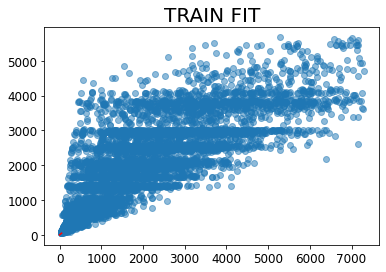

In [ ]:
plt.title('TRAIN FIT', fontsize=20)
plt.scatter(y_train, y_predicted_train, alpha = 0.5)
plt.plot([0, 50], [0, 50], c='red')

In [ ]:
# Importancia de variables para el modelo RandomForestRegressor
importances_rf = pd.DataFrame({'features' : X_train.columns.tolist() ,
                            'importance' : mod_rf_reg.feature_importances_}).sort_values('importance', ascending = False)

importances_rf.loc[importances_rf.importance > 0]

,features,importance
1,Item_MRP,0.554338
8,Outlet_Type_num_2,0.374128
2,Antiquity_Outlet,0.049473
0,Item_Visibility,0.008466
3,Item_Weight_3,0.007109
5,Item_Type_num_2,0.005165
12,Outlet_Location_Type_est,0.000432
6,Outlet_Size_num_2,0.000298
9,Item_Fat_Content_est,0.000227
4,Item_Fat_Content_num_2,0.000181


### Modelo XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor as xgb
from sklearn.model_selection import GridSearchCV

Se considera tunear los parámetros del modelo

In [ ]:
xgbr = xgb(gpu_id=0,learning_rate=0.3, max_depth=6, n_estimators=100,subsample=0.8)

# Parámetros para cross-validation

tuned_parameters = {
   'max_depth':[4,5],
   'min_child_weight':[2,3,4],
   'gamma':[i/10.0 for i in range(0,4)], 
   'learning_rate':[0.01,0.05,0.1], 
   'n_estimators':[100, 200]
}

clf = GridSearchCV(xgbr, param_grid = tuned_parameters,cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print( clf.best_params_)
print("Best score found on development set:")
print( clf.best_score_)

[00:20:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# Entrenamiento del modelo con los mejores parámetros
xgb_reg = xgb(gpu_id=0, learning_rate=0.05, gamma=0.0, max_depth=4, n_estimators=100, subsample=0.8, min_child_weight=4)
xgb_reg.fit(X_train, y_train)

[01:59:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(gamma=0.0, gpu_id=0, learning_rate=0.05, max_depth=4,
             min_child_weight=4, subsample=0.8)

In [ ]:
# Predicción variable target con el modelo
y_predicted_train = xgb_reg.predict(X_train)
y_predicted_test = xgb_reg.predict(X_test)

In [ ]:
# Métricas para el modelo XGBoost
metrics_xgb_reg = pd.DataFrame({'metric':['R2','MAE','MSE','MRE'],
                                'xgb_reg_train':[r2_score(y_train, y_predicted_train),
                                        mean_absolute_error(y_train, y_predicted_train),
                                        mean_squared_error(y_train, y_predicted_train),
                                        max_error(y_train, y_predicted_train)],

                                'xgb_reg_test':[r2_score(y_test, y_predicted_test),
                                        mean_absolute_error(y_test, y_predicted_test),
                                        mean_squared_error(y_test, y_predicted_test),
                                        max_error(y_test, y_predicted_test)]})
metrics_xgb_reg.round(3)

,metric,xgb_reg_train,xgb_reg_test
0,R2,0.640,0.579
1,MAE,682.607,746.129
2,MSE,905861.557,1060447.640
3,MRE,4432.907,4308.537


### Comparación final de métricas (Funciones de coste) por modelo en train y test

In [ ]:
metricsRes = pd.concat([metrics_sgd_reg, metrics_ridge_reg.drop('metric',axis=1), metrics_lasso_reg.drop('metric',axis=1), 
                        metrics_rf_reg.drop('metric',axis=1), metrics_xgb_reg.drop('metric',axis=1)], axis=1)
metricsRes.round(3)

,metric,sgd_reg_train,sgd_reg_test,ridge_reg_train,ridge_reg_test,lasso_reg_train,lasso_reg_test,rf_reg_train,rf_reg_test,xgb_reg_train,xgb_reg_test
0,R2,0.567,0.545,0.562,0.539,0.568,0.545,0.626,0.580,0.640,0.579
1,MAE,791.298,816.072,795.175,820.257,791.311,815.969,691.380,744.091,682.607,746.129
2,MSE,1088213.053,1146794.790,1102213.493,1161325.496,1087559.683,1145752.595,939387.593,1059256.597,905861.557,1060447.640
3,MRE,4499.522,4404.630,4504.619,4558.384,4502.573,4370.015,4540.780,4347.959,4432.907,4308.537


In [ ]:
# Comparando las métricas en train y test por modelo me quedo con el RandomForestRegressor

### Validación de correlación entre variables final

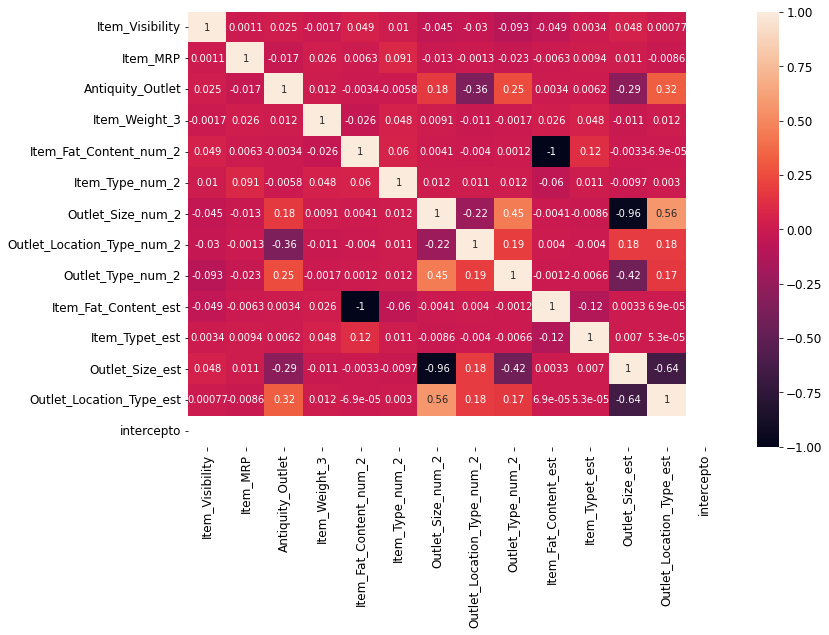

In [ ]:
# Validar correlaciones entre variables por principio de parcimonia
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), annot=True)
plt.show()

### Modelo estadístico para observar mejora de los modelos de machine learning

In [ ]:
# Modelo de regresión estadístico
import statsmodels.api as sm

# Fit y summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     644.4
Date:                Thu, 07 Jul 2022   Prob (F-statistic):               0.00
Time:                        01:59:39   Log-Likelihood:                -49417.
No. Observations:                5905   AIC:                         9.886e+04
Df Residuals:                    5892   BIC:                         9.895e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Item_Visibility     

In [ ]:
# H0: La variable no es importante para predecir el target
# Se rechaza la hipótesis nula cuando por lo general el P-value es menor al 0.05: Con un 95% de confianza se rechaza la H0

### Dataset de testeo

In [ ]:
df_val = pd.read_csv('/gdrive/MyDrive/Challenge PiData/data/Test_BigMart.csv')
df_val.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [ ]:
df_val.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [ ]:
df_val.Item_Fat_Content.replace({"low fat": 'Low Fat', "LF": 'Low Fat', "reg": 'Regular'}, inplace=True)

In [ ]:
# Completando valores nulos:
# Para Item_Weight:
df_2 = pd.DataFrame()
for i in df_val.Item_Identifier.unique():
  df_item = df_val[df_val['Item_Identifier'] == i]
  df_item['Item_Weight'].fillna(df_item['Item_Weight'].mean(), axis=0, inplace=True)
  df_2 = pd.concat([df_2, df_item], axis=0)
  df_2.reset_index(drop=True, inplace=True)
# Quedan producto que se compraron solo una vez y sin registro de Item_Weight, reemplazo por el valor de la mediana del total
df_2['Item_Weight'].fillna(df_2['Item_Weight'].median(), axis=0, inplace=True)
# Para Outlet_Size:
df_2['Outlet_Size'].fillna('Small', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
df_val = df_2.copy()

In [ ]:
# Reemplazo valores outlier por encima del percentil 98 por el valor de la mediana
p98 = np.percentile(df_val['Item_Visibility'], 98)
df_val['Item_Visibility'] = np.where(df_val['Item_Visibility'] > p98, df_val['Item_Visibility'].median(), df_val['Item_Visibility'])

#### Feature engineering

In [ ]:
df_val = df_val.merge(df_all_vars[['Item_Fat_Content','Item_Fat_Content_num_2']].drop_duplicates(), 
                      on=['Item_Fat_Content'], how='left')
df_val = df_val.merge(df_all_vars[['Item_Type','Item_Type_num_2']].drop_duplicates(), 
                      on=['Item_Type'], how='left')
df_val = df_val.merge(df_all_vars[['Outlet_Size','Outlet_Size_num_2']].drop_duplicates(), 
                      on=['Outlet_Size'], how='left')
df_val = df_val.merge(df_all_vars[['Outlet_Location_Type','Outlet_Location_Type_num_2']].drop_duplicates(), 
                      on=['Outlet_Location_Type'], how='left')
df_val = df_val.merge(df_all_vars[['Outlet_Type', 'Outlet_Type_num_2']].drop_duplicates(), 
                      on=['Outlet_Type'], how='left')

In [ ]:
df_val['Antiquity_Outlet'] = int(datetime.today().strftime('%Y')) - df_val['Outlet_Establishment_Year']
df_val['Item_Weight_3'] = df_val['Item_Weight']*df_val['Item_Weight']*df_val['Item_Weight']
df_val['Item_Fat_Content_est'] = np.where(df_val['Item_Fat_Content'] == 'Low Fat', 1, 0)
df_val['Item_Typet_est'] = np.where(df_val['Item_Type'] == 'Hard Drinks', 0, 1)
df_val['Outlet_Size_est'] = np.where(df_val['Outlet_Size'] == 'Small', 1, 0)
df_val['Outlet_Location_Type_est'] = np.where(df_val['Outlet_Location_Type'] == 'Tier 3', 1, 0)

In [ ]:
num_features = ['Item_Visibility','Item_MRP','Antiquity_Outlet',
                'Item_Weight_3','Item_Fat_Content_num_2', 'Item_Type_num_2', 'Outlet_Size_num_2',
                'Outlet_Location_Type_num_2','Outlet_Type_num_2']
cat_features = ['Item_Fat_Content_est', 'Item_Typet_est','Outlet_Size_est', 'Outlet_Location_Type_est']

X_val = df_val[num_features + cat_features]
X_val['intercepto'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Se predicen las ventas usando el modelo RandomForest entrenado

In [ ]:
# Predicción con modelo de regresión RandomForest
y_predicted_val_mod_rf_reg = mod_rf_reg.predict(X_val)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Output en dataset de test a enviar.
y_pred_test = pd.DataFrame(y_predicted_val_mod_rf_reg)
y_pred_test.columns = ['Item_Outlet_Sales_pred']
df_pred_test = pd.concat([df_val[['Item_Identifier','Outlet_Identifier']], y_pred_test], axis=1)
df_pred_test

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales_pred
0,FDW58,OUT049,4595.102876
1,FDW58,OUT017,4595.102876
2,FDW58,OUT018,4595.102876
3,FDW58,OUT046,4747.551684
4,FDW58,OUT045,4595.102876
...,...,...,...
5676,FDN04,OUT049,4595.102876
5677,FDT40,OUT049,4517.181107
5678,NCI29,OUT013,4586.595511
5679,FDP28,OUT027,4586.595511


### Conclusiones y observaciones:
* Me quedo con el modelo de RandomForest porque me genera mejor indicador de R2 y un overfitting controlado respecto al de XGBoost.
* Se validó que las variables que entran al modelo no presentan correlación entre si.
* Se tienen valores de R2 relativamente bajos y errores MAE altos.
* Se puede mejorar con un mejor Feature Engineering, tuve deficiencia en esto porque desconozco el valor de cada variable para el negocio y alguna técnica para ponderar el valor de las variables categóricas con las asunciones planteadas en el Challenge.
* El dataset no se ajusta a un modelo lineal, no se cumplen los supuestos.


### Fuentes de datos adicionales: 
* Nivel de urbanicidad de la ubicación de la tienda 
* Indicador que referencie que tan transitado es el lugar donde está ubicado la tienda 
* Nivel de cercanía a establecimientos que pueden generar competencia, por ende, rebajas de precios, 
* Temporalidad del producto, hay meses que puede tener menor o mayor precio. 
* Nivel de rotación, stock del producto.